# Visible Watermark Information Classification (VWIC)

## YOLO v8

This notebook is a prototype for training a YOLOv8 model using custom data.  More specifically, images that have been watermarked and annotated in Roboflow will be loaded and used in the pipeline.

The custom `RoboflowYOLOv8Loader` is required to load and transform data exported from Roboflow into the format and data structures required to use object detection in Tensorflow and train a YOLOv8 Model.

In [22]:
import os
import math

import keras
import keras_cv
import tensorflow as tf

# project utils
from lib.roboflow_yolov8_loader import RoboflowYOLOv8Loader
import lib.utils as utils

# Also possible to use jax or pytorch.
os.environ["KERAS_BACKEND"] = "tensorflow"

# Objects/Information we are trying to detect.
# numerical representation is based on list index.
CLASS_IDS = [
    "contact",  # contact information
    "identifier",  # image identifier
    "logo",  # a company logo
    "notice",  # copyright or other type of notice
]

DATA_DIR = "./visible-watermark-information-classification-voc2007.v9i.yolov8"

BOUNDING_BOX_FORMAT = "xyxy"
BATCH_SIZE = 4

VALUE_RANGE = (0, 1)

## Load the visual watermark detection data

The `RoboflowYOLOv8Loader` is then used to load and split the data into different sets required in the pipeline.

In [23]:
# construct custom dataset loader.
data_loader = RoboflowYOLOv8Loader(CLASS_IDS, DATA_DIR, batch_size=BATCH_SIZE)

# load dataset.
# split percentage is managed by Roboflow and exported.
train, val, test = data_loader.load_dataset()

# verify split percentage from Roboflow
utils.view_splits(train, val, test)

100%|██████████| 50/50 [00:00<00:00, 3775.25it/s]


         Dataset Splits          
   Split  Percentage
0  train        70.0
1    val        20.0
2   test        10.0


## Visualize the training data

The annotated training data is visualized below to verify that the custom loader has loaded and transformed the data, and that the bounding boxes are in the correct format and are accurate.  This is critical to ensuring the object detector has accurate data when training.  The validation data is also visualized to ensure that it is correct as well.  If the validation data was incorrect then model tuning would not work well because the metrics used to tune the model during training would be incorrect.

The Keras object detection pipeline requires the dataset to be in a specific format.  When loading the dataset, we used the following structure:

```python
{
    "images": Tensor(),
    "bounding_boxes": {
        "classes": Tensor(),
        "boxes": RaggedTensor()
    }
}
```

The bounding box format needs to be translated from a python dictionary to dense bounding box tensors and this is done using the dataset `map` function.

```python
{
    "images": Tensor(),
    "bounding_boxes": DenseTensor()
}
```

In [24]:
augmenters = [
    keras_cv.layers.RandomSaturation(factor=0.1),
    keras_cv.layers.RandomBrightness(factor=0.1, value_range=VALUE_RANGE),
    keras_cv.layers.RandomContrast(factor=0.1, value_range=VALUE_RANGE),
    keras_cv.layers.RandomHue(factor=0.1, value_range=VALUE_RANGE),
    keras_cv.layers.JitteredResize(
        target_size=(640, 640),
        scale_factor=(0.9, 1.1),
        bounding_box_format=BOUNDING_BOX_FORMAT
    )
]   

def create_augmenter_fn(augmenters):
    def augmenter_fn(inputs):
        for augmenter in augmenters:
            inputs = augmenter(inputs)
        return inputs

    return augmenter_fn

augmenter_fn = create_augmenter_fn(augmenters)


resizing = keras_cv.layers.Resizing(
    640, 640, bounding_box_format=BOUNDING_BOX_FORMAT, pad_to_aspect_ratio=True
)

def dict_to_tuple(inputs):
    return inputs["images"], keras_cv.bounding_box.to_dense(
        inputs["bounding_boxes"], max_boxes=30
    )

TRAINING_SET_SIZE = len(train) # get total value before augmentation and batching
STEPS_PER_EPOCH = math.floor(TRAINING_SET_SIZE / BATCH_SIZE)
NUM_EPOCHS = 150

# load into correct format for the model
train_ds = ( train
                .shuffle(BATCH_SIZE * len(CLASS_IDS))
                .ragged_batch(BATCH_SIZE, drop_remainder=True)
                .map(augmenter_fn, num_parallel_calls=tf.data.AUTOTUNE)
                .map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
                .prefetch(tf.data.AUTOTUNE)
           )

val_ds =   ( val
                .ragged_batch(BATCH_SIZE, drop_remainder=True)
                .map(resizing, num_parallel_calls=tf.data.AUTOTUNE)
                .map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
                .prefetch(tf.data.AUTOTUNE)
           )

test_ds =  ( test
                .ragged_batch(BATCH_SIZE, drop_remainder=True)
                .map(resizing, num_parallel_calls=tf.data.AUTOTUNE)
                .map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
                .prefetch(tf.data.AUTOTUNE)
           )

TRAINING DATA


2025-03-23 16:26:47.803650: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 13325638926881863262
2025-03-23 16:26:47.804109: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 1747232340257386486


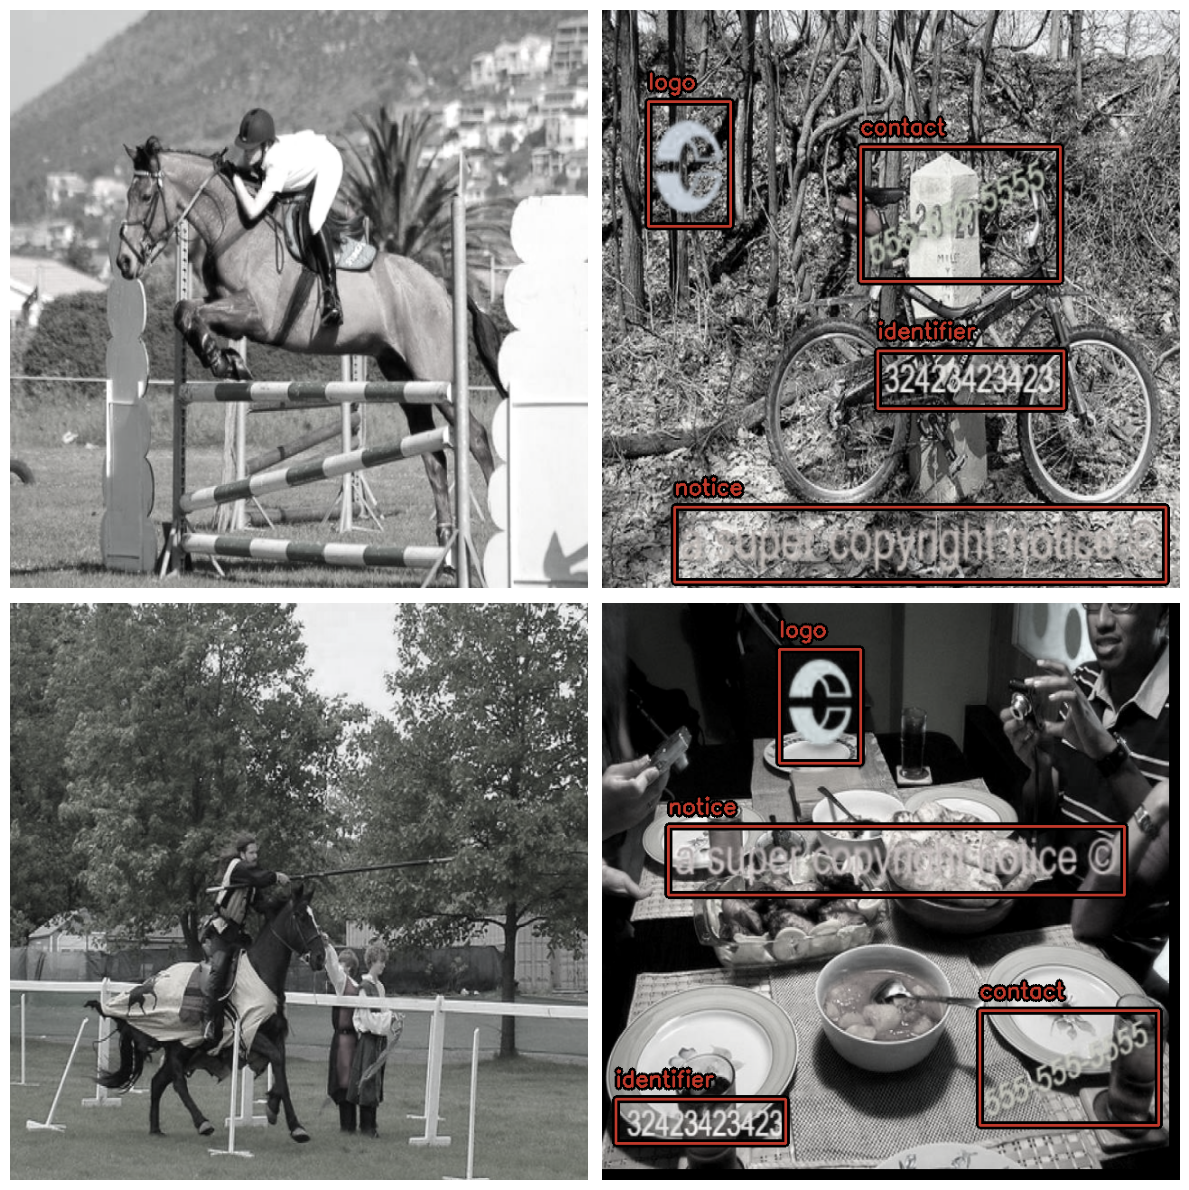

In [25]:
# visualize the training split.
print("TRAINING DATA")
utils.visualize_dataset(
    train_ds,
    data_loader.class_mapping,
    bounding_box_format=BOUNDING_BOX_FORMAT, 
    rows=2, cols=2, 
)

VALIDATION DATA


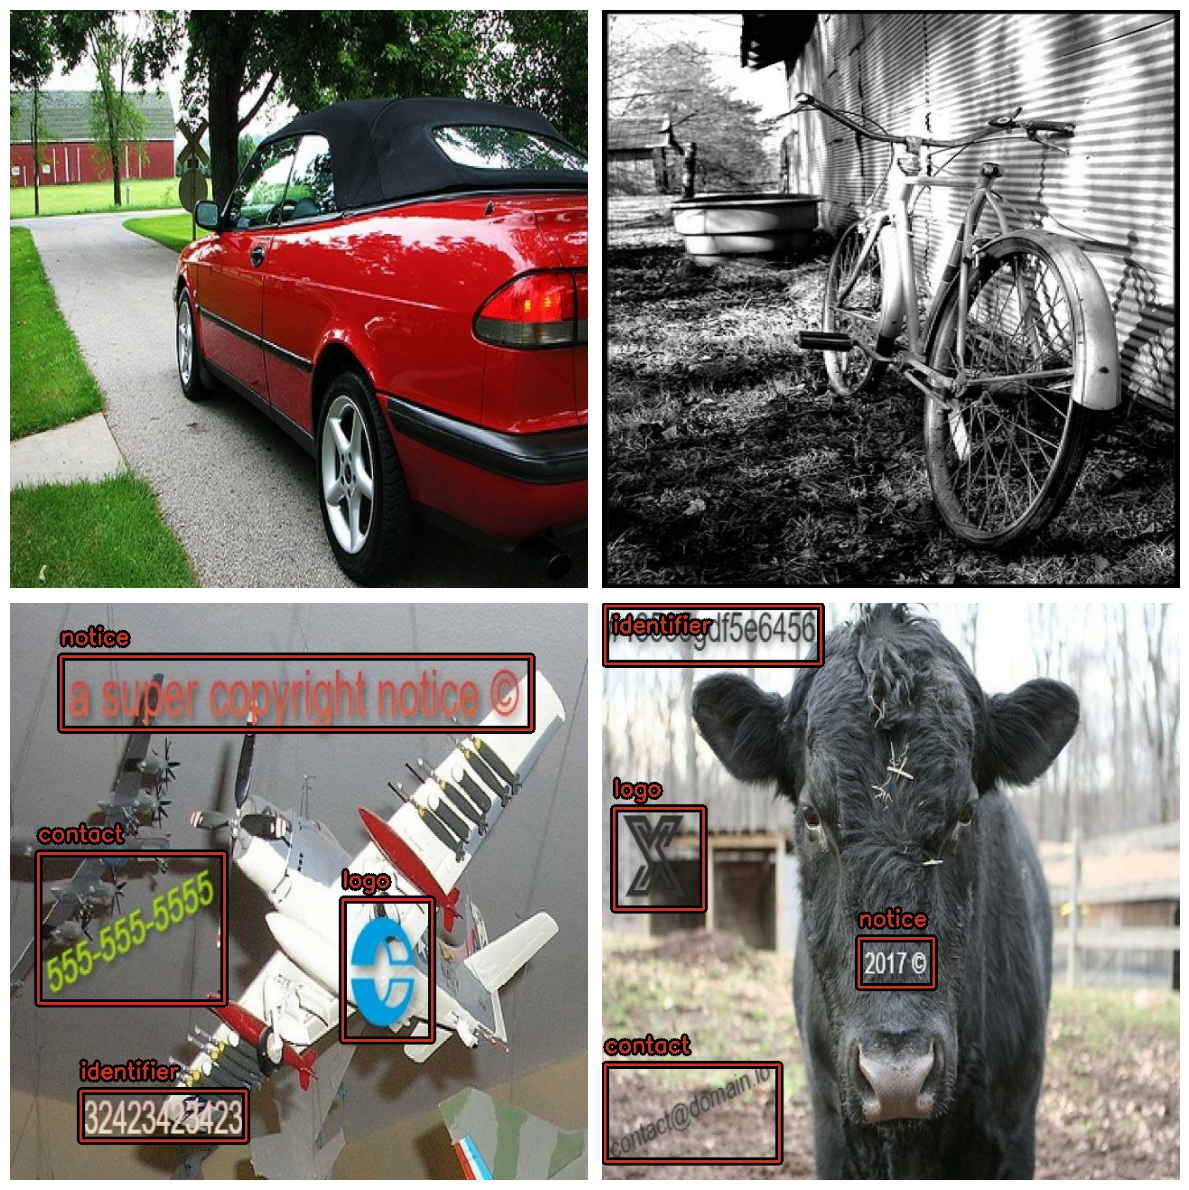

In [26]:
print("VALIDATION DATA")
utils.visualize_dataset(
    val_ds,
    data_loader.class_mapping,
    bounding_box_format=BOUNDING_BOX_FORMAT,
    rows=2,
    cols=2,
)

In [27]:
# small dataset requires small model otherwise we risk overfitting.
# load weights of backbone so that it can then be fine-tuned to the dataset.

backbone = keras_cv.models.YOLOV8Backbone.from_preset(
    "yolo_v8_s_backbone_coco", load_weights=True
)

model = keras_cv.models.YOLOV8Detector(
    num_classes=len(CLASS_IDS),
    bounding_box_format=BOUNDING_BOX_FORMAT,
    backbone=backbone,
    # fpn_depth=3,
)

initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate,
    decay_steps=math.floor(STEPS_PER_EPOCH * NUM_EPOCHS),
    alpha=0.0,
)

optimizer = keras.optimizers.Adam(learning_rate=lr_schedule, global_clipnorm = 8.0)

model.compile(
    classification_loss="binary_crossentropy",
    box_loss=keras_cv.losses.CIoULoss(bounding_box_format=BOUNDING_BOX_FORMAT),
    optimizer=optimizer,
)

## Train the YOLOv8 model using custom watermark dataset

The code below leverages functions available in the Keras computer vision library to help visualize model predictions so that they can be evaluated visually after each epoch.  This helps to understand the progress and give a visual representation of the mapping between detections and COCO metrics used when training the model.

Note: The model doesn't show very good accuracy at this stage, and doesn't have to.  With the successful training of the model, we can validate that the entire workflow (watermarking, annotation, loading and processing) works to format the data as required to train the model.

In [28]:
class VisualizeDetections(keras.callbacks.Callback):
    """Used to visualize detection progress after each epoch.
    Reference: https://keras.io/examples/vision/yolov8/
    """
    def on_epoch_end(self, epoch, logs):
        utils.visualize_detections(
            self.model,
            bounding_box_format=BOUNDING_BOX_FORMAT,
            dataset=val_ds,
            class_mapping=data_loader.class_mapping,
        )

# Train the YOLOv8 model using custom watermark image dataset.
model.fit(
    train_ds,
    validation_data=val_ds,
    steps_per_epoch=STEPS_PER_EPOCH, # matches decay_steps for regularization
    epochs=NUM_EPOCHS,  # early stopping callback may mean this is never reached.
    callbacks=[
        # Tuning the model based on metrics from this callback has been very inconsistent. 
        # This is left here for demonstration purposes, but should be replaced.
        # Github issues:
        #   - https://github.com/keras-team/keras-cv/issues/2402
        #   - https://github.com/keras-team/keras-cv/issues/2442
        keras_cv.callbacks.PyCOCOCallback(  # COCO metrics (AP/AR @ IOU)
            val_ds,
            bounding_box_format=BOUNDING_BOX_FORMAT,
        ),
        keras.callbacks.TensorBoard(  # training progress visualization
            log_dir="training_logs"
        ),
        keras.callbacks.ModelCheckpoint(
            filepath="./model/best_model.keras",
            monitor="val_loss",     # using combination of class/box loss since PyCOCOCallback unreliable.
            save_best_only=True,  # Only keep the best model
            verbose=1,
        ),
        keras.callbacks.EarlyStopping(
            patience=7,
            monitor="val_loss", # using combination of class/box loss since PyCOCOCallback unreliable.
            verbose=1,
            restore_best_weights=True,  # Restore weights of the best epoch
        ),
        # VisualizeDetections(),  # visual validation after each epoch
    ],
    # verbose=0,  # suppress epoch output since monitoring in TensorBoard.
)

Epoch 1/150


/home/gb/vwic/keras_cv/.venv/lib/python3.12/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_933']
Received: inputs=Tensor(shape=(4, 640, 640, 3))
  warnings.warn(msg)


25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/stepp - box_loss: 1.1567e-04 - class_loss: 307.4343 - l
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.34s).
Accumulating evaluation results...
DONE (t=0.06s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.001
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ]

2025-03-23 16:29:52.629182: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19663200 bytes after encountering the first element of size 19663200 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.21s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 

2025-03-23 16:30:07.894906: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19663200 bytes after encountering the first element of size 19663200 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.00s).
Accumulating evaluation results...
Please run evaluate() first
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = -1.000
 Avera

2025-03-23 16:31:15.407072: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19663200 bytes after encountering the first element of size 19663200 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.00s).
Accumulating evaluation results...
Please run evaluate() first
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = -1.000
 Avera

2025-03-23 16:31:38.366034: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19663200 bytes after encountering the first element of size 19663200 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - box_loss: 9.8102e-05 - class_loss: 8.8255 - loss: 8.8256

2025-03-23 16:31:48.962314: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19663200 bytes after encountering the first element of size 19663200 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.00s).
Accumulating evaluation results...
Please run evaluate() first
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = -1.000
 Avera

2025-03-23 16:31:53.588958: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19663200 bytes after encountering the first element of size 19663200 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step  - box_loss: 9.2909e-05 - class_loss: 5.3656 
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.00s).
Accumulating evaluation results...
Please run evaluate() first
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95

2025-03-23 16:33:50.719557: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19663200 bytes after encountering the first element of size 19663200 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/stepp - box_loss: 7.2123e-05 - class_loss: 1.6488 -
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.008
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.021
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.004
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.015
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.005
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.087
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.098
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0

2025-03-23 16:34:49.842753: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19663200 bytes after encountering the first element of size 19663200 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.06s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.039
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.097
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.020
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.072
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.042
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.113
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.137
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.138
 Average Recall     (AR) @[ IoU=0.50:0.95 

2025-03-23 16:35:22.991235: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19663200 bytes after encountering the first element of size 19663200 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.13s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.007
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.039
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.001
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.022
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.118
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.138
 Average Recall     (AR) @[ IoU=0.50:0.95 

2025-03-23 16:36:27.607311: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19663200 bytes after encountering the first element of size 19663200 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.12s).
Accumulating evaluation results...
DONE (t=0.05s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.094
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.198
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.081
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.100
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.136
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.238
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.337
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.338
 Average Recall     (AR) @[ IoU=0.50:0.95 

2025-03-23 16:37:00.373932: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19663200 bytes after encountering the first element of size 19663200 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.10s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.094
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.197
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.079
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.126
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.110
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.259
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.340
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.345
 Average Recall     (AR) @[ IoU=0.50:0.95 

2025-03-23 16:37:18.419676: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19663200 bytes after encountering the first element of size 19663200 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.14s).
Accumulating evaluation results...
DONE (t=0.05s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.128
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.249
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.131
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.166
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.153
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.290
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.379
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.381
 Average Recall     (AR) @[ IoU=0.50:0.95 

2025-03-23 16:39:28.746799: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.16s).
Accumulating evaluation results...
DONE (t=2.70s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.161
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.293
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.151
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.206
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.145
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.345
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.426
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.427
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.

2025-03-23 16:40:48.228382: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19663200 bytes after encountering the first element of size 19663200 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.14s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.176
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.316
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.185
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.213
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.152
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.396
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.502
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.506
 Average Recall     (AR) @[ IoU=0.50:0.95 

2025-03-23 16:47:24.086890: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19663200 bytes after encountering the first element of size 19663200 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.18s).
Accumulating evaluation results...
DONE (t=0.05s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.155
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.282
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.156
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.190
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.191
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.378
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.485
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.489
 Average Recall     (AR) @[ IoU=0.50:0.95 

## Final visualization on test data

After the model has been fine-tuned with the custom training and validation data, it is essential to evaluate the models ability to generalize to unseen data.  To do this we need to use the test set, since it was not used during the training process. (Simple hold off.)

This method may be evolved as-needed throughout the project to improve the accuracy of the detector.

/home/gb/vwic/keras_cv/.venv/lib/python3.12/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_933']
Received: inputs=Tensor(shape=(4, 640, 640, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


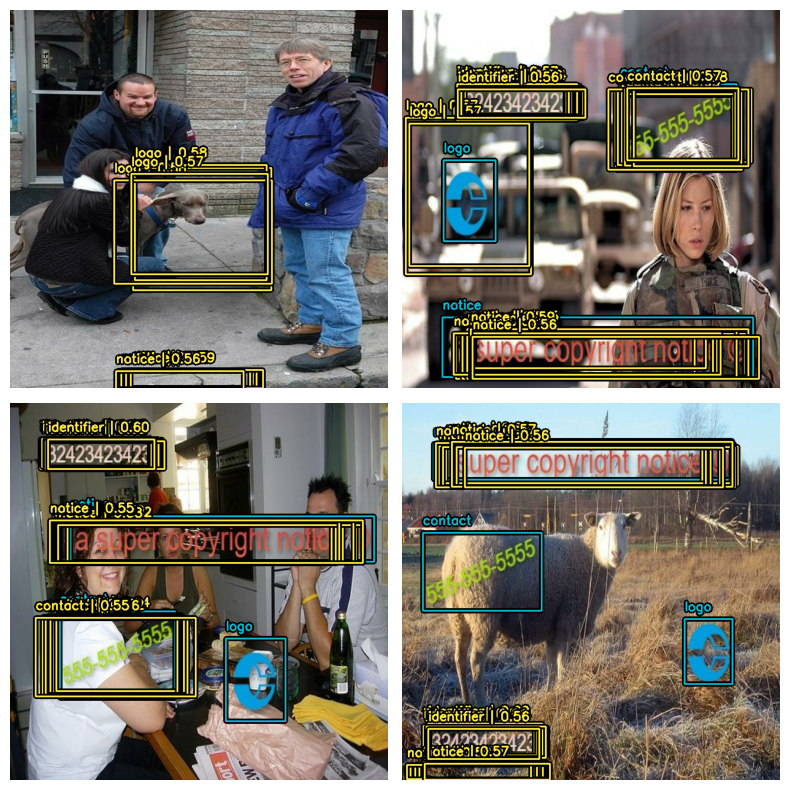

evaluating...:   0%|          | 0/12 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


evaluating...:   8%|▊         | 1/12 [00:00<00:06,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


evaluating...:  17%|█▋        | 2/12 [00:00<00:03,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


evaluating...:  25%|██▌       | 3/12 [00:00<00:02,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


evaluating...:  33%|███▎      | 4/12 [00:01<00:01,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


evaluating...:  42%|████▏     | 5/12 [00:01<00:01,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


evaluating...:  50%|█████     | 6/12 [00:01<00:01,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


evaluating...:  58%|█████▊    | 7/12 [00:01<00:01,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


evaluating...:  67%|██████▋   | 8/12 [00:02<00:00,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


evaluating...:  75%|███████▌  | 9/12 [00:02<00:00,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


evaluating...:  83%|████████▎ | 10/12 [00:02<00:00,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


evaluating...:  92%|█████████▏| 11/12 [00:02<00:00,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


evaluating...: 100%|██████████| 12/12 [00:02<00:00,  4.35it/s]


         COCO Metrics            
                         Metric     Value
0                           MaP  0.206400
1                  MaP@[IoU=50]  0.360970
2                  MaP@[IoU=75]  0.223563
3              MaP@[area=small]  0.000000
4             MaP@[area=medium]  0.215108
5              MaP@[area=large]  0.216090
6     Recall@[max_detections=1]  0.403804
7    Recall@[max_detections=10]  0.514130
8   Recall@[max_detections=100]  0.525000
9           Recall@[area=small]  0.000000
10         Recall@[area=medium]  0.489504
11          Recall@[area=large]  0.479243


In [37]:
model.prediction_decoder = keras_cv.layers.NonMaxSuppression(
    bounding_box_format=BOUNDING_BOX_FORMAT,
    from_logits=True,
    iou_threshold=0.5,
    confidence_threshold=0.55,
)

utils.visualize_detections(
    model,
    dataset=test_ds,
    bounding_box_format=BOUNDING_BOX_FORMAT,
    class_mapping=data_loader.class_mapping,
)

utils.evaluate_coco_metrics(model, test_ds, BOUNDING_BOX_FORMAT)


# References

[1] Team, Keras. “Keras Documentation: Efficient Object Detection with YOLOV8 and KerasCV.” Keras.io, keras.io/examples/vision/yolov8/.


[2] K. Team, “Keras documentation: Keras API reference,” keras.io. https://keras.io/api/
‌